#Q1)Write a function to generate an m+1 dimensional data set, of size n, consisting of m continuous independent variables (X) and one dependent binary variable (Y) defined as;

#$p(y=1|x) = \frac{1}{1 + e^{-X \cdot
\beta}}$
$Y = \begin{cases}
    1 & \text{if } p(y=1|x)= \frac{1}{1 + e^{-X \cdot
\beta}} > 0.5 \\
    \text{otherwise} &
  \end{cases}$


---
where,


*   β: is a random vector of dimensionality m + 1, representing the coefficients of the linear relationship
between X and Y,
*   ∀i ∈ [1,n], $x_{i0} = 1$ \\
function should take the following parameters:\\

To add noise to the labels (Y) generated, we assume a Bernoulli distribution with probability of success, θ,
that determines whether or not the label generated, as above, is to be flipped. The larger the value of θ, the
greater is the noise. \\
The function should take the following parameters:

*   θ:The probability of flipping the label, Y
*   n:The size of the data set
*   m:The number of indepedent variables

output from the function should be, \\


*   X:An n x m numpy array of independent variable values (with a 1 in the first column)
*   Y:The n x 1 numpy array of output values
*   β: The random coefficients used to generatre Y from X




---



In [44]:
import numpy as np

def generate_dataset(theta, n, m):
    beta = np.random.normal(size=m+1)
    beta /= np.linalg.norm(beta)
    X = np.random.normal(size=(n, m))
    X = np.hstack((np.ones((n, 1)), X))

    p = 1 / (1 + np.exp(-np.dot(X, beta)))
    Y = (p > 0.5).astype(int)
    flip = np.random.binomial(1, theta, size=n)
    Y = np.logical_xor(Y, flip).astype(int)

    return X, Y, beta


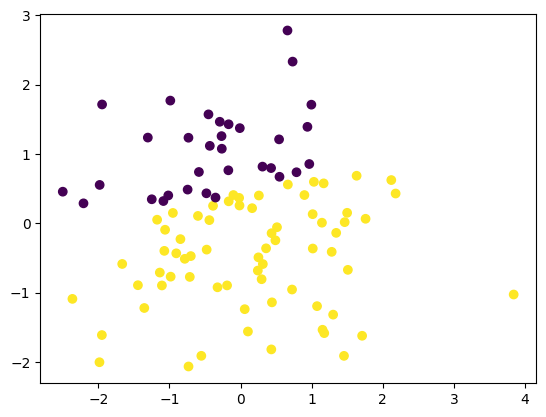

In [48]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Dataset without flipping
def generate_dataset_without_flipping(theta, n, m):
    beta = np.random.normal(size=m+1)
    X = np.random.normal(size=(n, m))
    X = np.hstack((np.ones((n, 1)), X))

    p = 1 / (1 + np.exp(-X.dot(beta)))
    Y = (p > 0.5).astype(int)

    return X, Y, beta
X, Y, beta = generate_dataset_without_flipping(0.1, 100, 2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y)
plt.show()


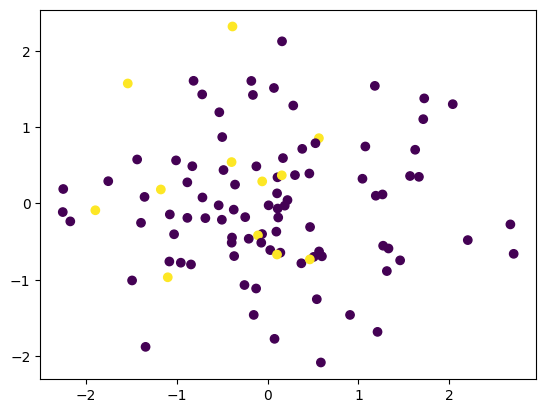

In [51]:
#Dataset with flip
X, Y, beta = generate_dataset(0.1, 100, 2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y)
plt.show()


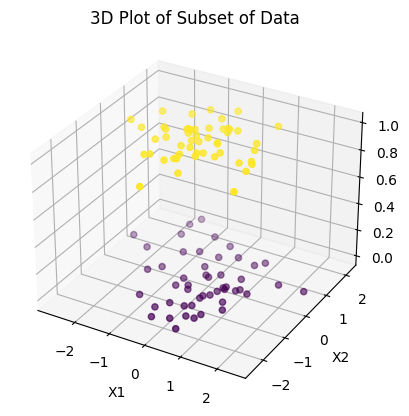

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#Data visualization

theta = 0.5
n = 1000
m = 2


X, Y, _ = generate_dataset(theta, n, m)

subset_size = 100
subset_indices = np.random.choice(n, subset_size, replace=False)
X_subset = X[subset_indices]
Y_subset = Y[subset_indices]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_subset[:, 1], X_subset[:, 2], Y_subset, c=Y_subset, cmap='viridis')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title('3D Plot of Subset of Data')

plt.show()


# Q2) Write a function that learns the parameters of a logistic regression line given inputs


---


*   X:An n x m numpy array of independent variable values

*   Y:The n x 1 numpy array of output values
*   κ:the number of iteractions (epochs)


*   τ:the threshold on change in Cost function value from the previous to current iteration
*   λ:the learning rate for Gradient Descent \\

The function should implement the Gradient Descent algorithm as discussed in class that initialises β with
random values and then updates these values in each iteraction by moving in the the direction defined by
the partial derivative of the cost function with respect to each of the coefficients. The function should use
only one loop that ends after a number of iterations (κ) or a threshold on the change in cost function value
(τ). \\
The output should be an m + 1 dimensional vector of coefficients and the final cost function value


---

In [53]:
import numpy as np
#k: number of iteractions (epochs)
#tau: threshold on change in Cost function value from the previous to current iteration
#lamda:λ:the learning rate for Gradient Descent
def logistic_regression(X, Y, k, tau, learning_rate):
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    std_X[std_X == 0] = 1e-8
    X_normalized = (X - mean_X) / std_X
    beta = np.random.normal(size=X_normalized.shape[1])
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    cost = np.inf

    for _ in range(k):
        p = sigmoid(X_normalized.dot(beta))
        gradient = X_normalized.T.dot(p - Y)
        beta -= learning_rate * gradient
        new_cost = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))

        if np.abs(new_cost - cost) < tau:
            break

        cost = new_cost

    return beta, cost


#Q3) Create a report investigating how different values of n and θ impact the ability for your logistic regression function to learn the coefficients, β, used to generate the output vector Y . Also include your derivation of the partial derivative of the cost function with respect to the parameters of the model.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

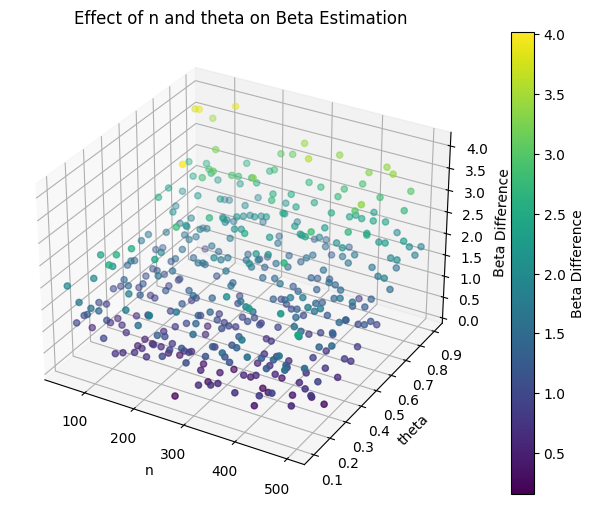

In [55]:
#3D Scatter plot
num_samples = 20
n_values = np.linspace(50, 500, num_samples, dtype=int)
theta_values = np.linspace(0.1, 0.9, num_samples)
m = 3
k = 1000
tau = 1e-6
learning_rate = 0.01

n_mesh, theta_mesh = np.meshgrid(n_values, theta_values)
beta_diff = np.zeros_like(n_mesh, dtype=float)

for i in range(num_samples):
    for j in range(num_samples):
        n = n_values[i]
        theta = theta_values[j]

        X, Y, true_beta = generate_dataset(theta, n, m)
        estimated_beta, _ = logistic_regression(X, Y, k, tau, learning_rate)

        beta_diff[j, i] = np.linalg.norm(true_beta - estimated_beta)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(n_mesh, theta_mesh, beta_diff, c=beta_diff, cmap='viridis')
ax.set_xlabel('n')
ax.set_ylabel('theta')
ax.set_zlabel('Beta Difference')
ax.set_title('Effect of n and theta on Beta Estimation')


cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Beta Difference')

plt.show()


<ipython-input-53-aaa51d4a8f3f>:18: RuntimeWarning: divide by zero encountered in log
  new_cost = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))
<ipython-input-53-aaa51d4a8f3f>:18: RuntimeWarning: invalid value encountered in multiply
  new_cost = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))


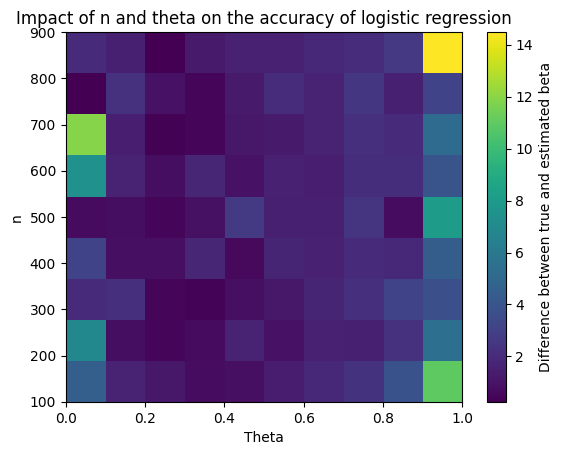

In [76]:
#Heatmaps

n_values = np.arange(100, 1000, 100)
theta_values = np.linspace(0, 1, 10)
k = 1000
tau = 1e-5
learning_rate= 0.01

results = np.zeros((len(n_values), len(theta_values)))
for i, n in enumerate(n_values):
    for j, theta in enumerate(theta_values):
        X, Y, beta_true = generate_dataset(theta, n, m)
        beta_est, _ = logistic_regression(X, Y, k, tau, learning_rate)
        results[i, j] = np.linalg.norm(beta_true - beta_est)


plt.imshow(results, extent=[theta_values.min(), theta_values.max(), n_values.min(), n_values.max()], origin='lower', aspect='auto')
plt.colorbar(label='Difference between true and estimated beta')
plt.xlabel('Theta')
plt.ylabel('n')
plt.title('Impact of n and theta on the accuracy of logistic regression')
plt.show()


<ipython-input-53-aaa51d4a8f3f>:18: RuntimeWarning: divide by zero encountered in log
  new_cost = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))
<ipython-input-53-aaa51d4a8f3f>:18: RuntimeWarning: invalid value encountered in multiply
  new_cost = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))
<ipython-input-53-aaa51d4a8f3f>:20: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(new_cost - cost) < tau:


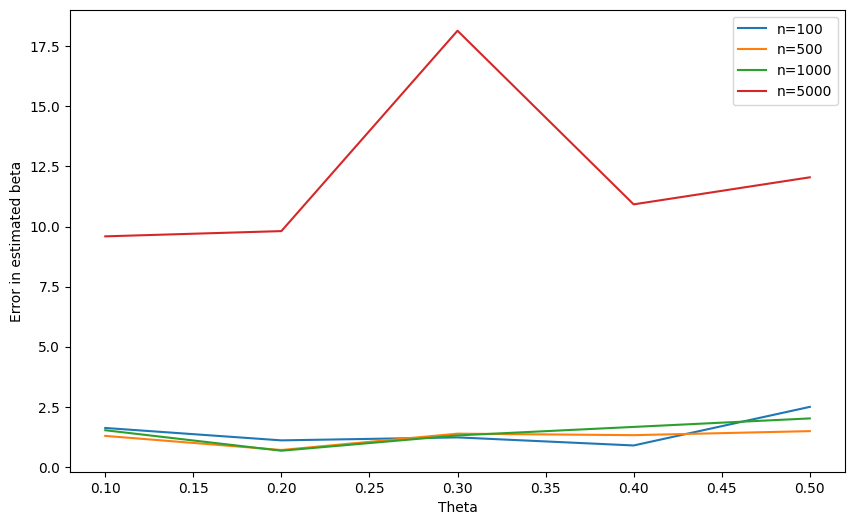

In [57]:
#Line plot

n_values = [100, 500, 1000, 5000]
theta_values = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {}


for n in n_values:
    for theta in theta_values:
        X, Y, true_beta = generate_dataset(theta, n, 10)
       # Train
        estimated_beta, cost = logistic_regression(X, Y, 1000, 1e-6, 0.01)
        error = np.linalg.norm(true_beta - estimated_beta)
        results[(n, theta)] = error

plt.figure(figsize=(10, 6))
for n in n_values:
    errors = [results[(n, theta)] for theta in theta_values]
    plt.plot(theta_values, errors, label=f'n={n}')
plt.xlabel('Theta')
plt.ylabel('Error in estimated beta')
plt.legend()
plt.show()


*   As n increases, the logistic regression model has more data to learn from, which generally improves the accuracy of the estimated coefficients beta
*   θ is the noise level in the labels. As theta increases, the labels become more noisy, making it harder for the logistic regression model to learn the true coefficients beta

* if n is too large, it may lead to overfitting, where the model learns the noise in the data instead of the underlying pattern
* If theta is too high, the model may learn from the noise instead of the underlying pattern, leading to poor generalization performance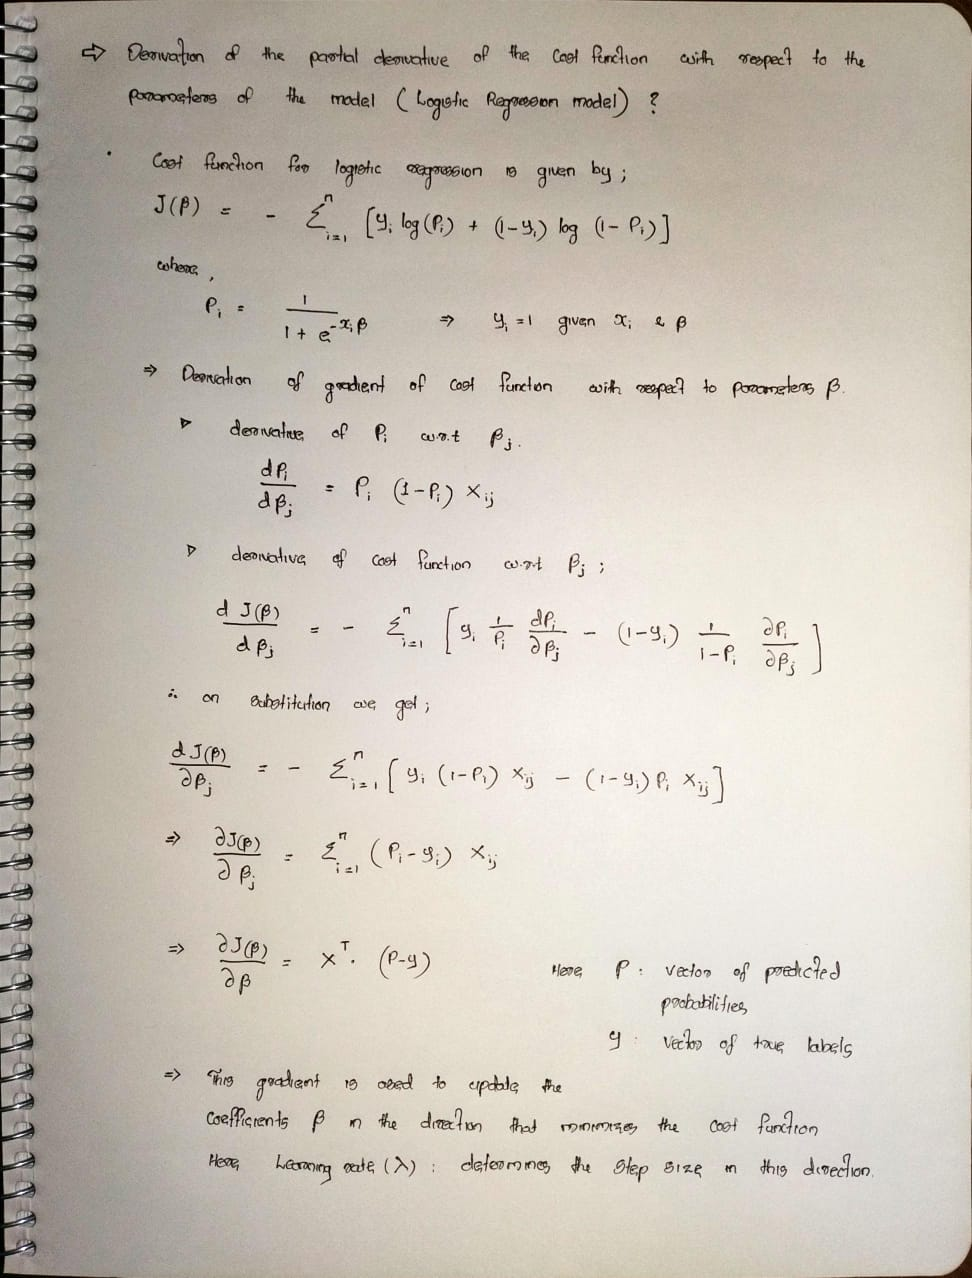

#Q4)Add L1 and L2 regularization to the Logistic Regression cost function. How does this impact the models learnt? How does the choice of regularization constant impact the β vector learned?

In [65]:
def logistic_regression_regularized(X, Y, k, tau, learning_rate, lambda_L1=0, lambda_L2=0):
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    std_X[std_X == 0] = 1e-8
    X_normalized = (X - mean_X) / std_X


    beta = np.random.normal(size=X_normalized.shape[1])

    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    cost = np.inf

    for _ in range(k):
        p = sigmoid(X_normalized.dot(beta))
        gradient = X_normalized.T.dot(p - Y)

        # Regularization terms
        gradient += lambda_L1 * np.sign(beta) + 2 * lambda_L2 * beta

        beta -= learning_rate * gradient
        new_cost = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))
        regularization_term = lambda_L1 * np.sum(np.abs(beta)) + lambda_L2 * np.sum(beta**2)
        new_cost += regularization_term


        if np.abs(new_cost - cost) < tau:
            break

        cost = new_cost

    return beta, cost


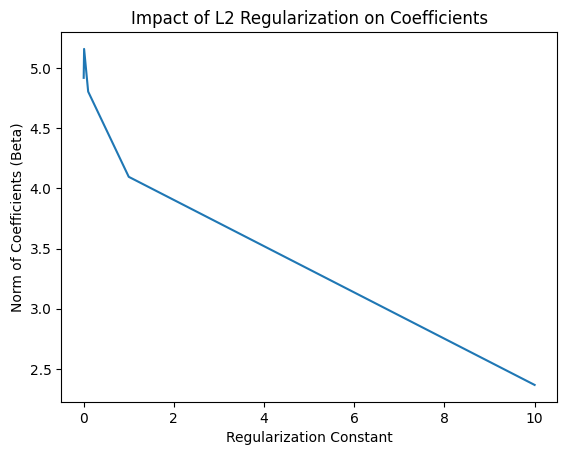

In [66]:
#Impact of L2 regularization on coefficients

def plot_coefficients_vs_regularization(X, Y, k, tau, learning_rate, lambda_values, regularization_type='L2'):
    coefficient_norms = []

    for lambda_val in lambda_values:
        if regularization_type == 'L1':
            beta, _ = logistic_regression_regularized(X, Y, k, tau, learning_rate, lambda_L1=lambda_val)
        elif regularization_type == 'L2':
            beta, _ = logistic_regression_regularized(X, Y, k, tau, learning_rate, lambda_L2=lambda_val)
        else:
            raise ValueError("Regularization type must be 'L1' or 'L2'.")

        coefficient_norms.append(np.linalg.norm(beta))

    plt.plot(lambda_values, coefficient_norms)
    plt.xlabel('Regularization Constant')
    plt.ylabel('Norm of Coefficients (Beta)')
    plt.title(f'Impact of {regularization_type} Regularization on Coefficients')
    plt.show()

# Example usage:
lambda_values = [0.001, 0.01, 0.1, 1, 10]
plot_coefficients_vs_regularization(X, Y, k, tau, learning_rate, lambda_values, regularization_type='L2')


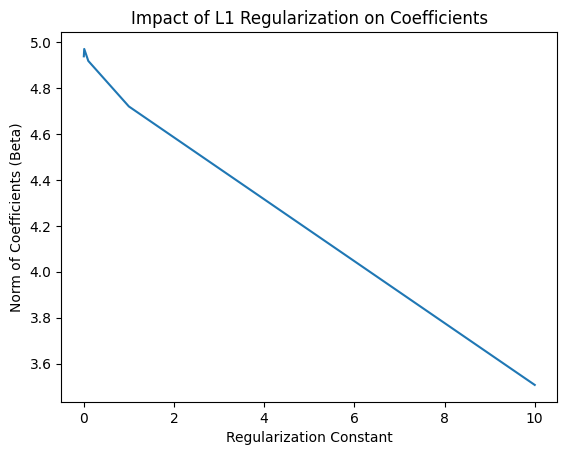

In [67]:
#Impact of L1 regularization on coefficients

def plot_coefficients_vs_regularization(X, Y, k, tau, learning_rate, lambda_values, regularization_type='L1'):
    coefficient_norms = []

    for lambda_val in lambda_values:
        if regularization_type == 'L1':
            beta, _ = logistic_regression_regularized(X, Y, k, tau, learning_rate, lambda_L1=lambda_val)
        elif regularization_type == 'L2':
            beta, _ = logistic_regression_regularized(X, Y, k, tau, learning_rate, lambda_L2=lambda_val)
        else:
            raise ValueError("Regularization type must be 'L1' or 'L2'.")

        coefficient_norms.append(np.linalg.norm(beta))

    plt.plot(lambda_values, coefficient_norms)
    plt.xlabel('Regularization Constant')
    plt.ylabel('Norm of Coefficients (Beta)')
    plt.title(f'Impact of {regularization_type} Regularization on Coefficients')
    plt.show()

# Example usage:
lambda_values = [0.001, 0.01, 0.1, 1, 10]
plot_coefficients_vs_regularization(X, Y, k, tau, learning_rate, lambda_values, regularization_type='L1')


#How does this impact the models learnt?
Regularization helps to prevent overfitting by penalizing large coefficients. This means that the model will be less likely to fit to the noise in the training data, and more likely to generalize well to unseen data.


L1 regularization (also known as Lasso) tends to create sparser solutions, effectively performing feature selection by driving some coefficients to zero.


L2 regularization (also known as Ridge) tends to spread the coefficient values out more evenly, and usually doesn’t result in zero coefficients. It’s more about shrinking the coefficients towards zero.
#How does the choice of regularization constant impact the β vector learned?
The regularization constants lambda_L1 and lambda_L2 control the amount of regularization applied. A larger value means more regularization, which results in smaller coefficients.
For L1 regularization, a larger lambda_L1 will drive more coefficients to zero, effectively eliminating the corresponding features from the model.
For L2 regularization, a larger lambda_L2 will shrink the coefficients towards zero, but it won’t set any of them exactly to zero (unless the regularization is so strong that all coefficients are driven to zero).

The impact on the model and the β vector depends on the choice of regularization constant and the type of regularization used. Regularization can help to prevent overfitting and can also perform feature selection (in the case of L1 regularization). The optimal choice of regularization constant usually requires some kind of model selection or cross-validation procedure.

#Q5) Merge the linear regression code base created in Exercise 1 and the logistic regression code base created in this Excercise and create an object oriented code base that maximises reuse of code across the algorithms.


In [68]:
import numpy as np

class Regression:
    def __init__(self, learning_rate=0.01, tau=1e-5):
        self.learning_rate = learning_rate
        self.tau = tau

    def normalize_features(self, X):
        mean_X = np.mean(X, axis=0)
        std_X = np.std(X, axis=0)
        std_X[std_X == 0] = 1e-8
        return (X - mean_X) / std_X

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _gradient_descent(self, X, Y, beta):
        raise NotImplementedError

    def fit(self, X, Y, **kwargs):
        X_normalized = self.normalize_features(X)
        beta = np.random.normal(size=X_normalized.shape[1])
        self.beta, self.cost = self._gradient_descent(X_normalized, Y, beta, **kwargs)
        return self.beta, self.cost

class LogisticRegression(Regression):
    def __init__(self, learning_rate=0.01, tau=1e-5):
        super().__init__(learning_rate, tau)

    def _gradient_descent(self, X, Y, beta, k=1000):
        cost = np.inf
        for _ in range(k):
            p = self.sigmoid(X.dot(beta))
            gradient = X.T.dot(p - Y)
            beta -= self.learning_rate * gradient
            new_cost = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))
            if np.abs(new_cost - cost) < self.tau:
                break
            cost = new_cost
        return beta, cost

class LinearRegression(Regression):
    def __init__(self, learning_rate=0.01, tau=1e-5):
        super().__init__(learning_rate, tau)

    def _gradient_descent(self, X, Y, beta, kappa=1000, lamda=0.01):
        prev_cost = np.inf
        for i in range(kappa):
            Y_pred = np.dot(X, beta)
            error = Y_pred - Y
            gradient = np.dot(X.T, error)
            beta -= lamda * gradient
            cost = np.mean((error) ** 2)
            if abs(cost - prev_cost) < self.tau:
                break
            prev_cost = cost
        return beta, cost

# Example;
if __name__ == "__main__":
    X = np.random.randn(100, 3)
    Y = np.random.randint(0, 2, size=100)

    logistic_model = LogisticRegression()
    logistic_model.fit(X, Y)
    print("Logistic Regression Coefficients:", logistic_model.beta)
    print("Logistic Regression Cost:", logistic_model.cost)

    linear_model = LinearRegression()
    linear_model.fit(X, Y)
    print("Linear Regression Coefficients:", linear_model.beta)
    print("Linear Regression Cost:", linear_model.cost)


Logistic Regression Coefficients: [ 0.04286546 -0.07352631  0.04405187]
Logistic Regression Cost: 69.20623290992096
Linear Regression Coefficients: [ 0.01088168 -0.01846063  0.0109383 ]
Linear Regression Cost: 0.559458049648249
